## Validation plots for reconstruction-level HFS reconstruction

This uses sums over Energy Flow candidates to form the Hadronic Final State.


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import math

import uproot3

rc('text', usetex=True)

import matplotlib as mpl

mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

ebeam_e = 27.6
ebeam_p = 920



infile_name = 'mini-tree.root'

/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Read in the minitree root file into a pandas dataframe

In [2]:
ur_file = uproot3.open(infile_name)
print (ur_file.keys()) 
ur_tree = ur_file['minitree']
print(ur_tree)
mc   =  ur_tree.pandas.df(['*'], entrystop=3e7,flatten=True)
mc

[b'minitree;1']
<TTree b'minitree' at 0x00011c50e7c0>


,Q2_e,Q2_sigma,Q2_esigma,Q2_da,gen_Q2,y_e,y_sigma,y_esigma,y_da,HFS_px,...,gen_HFS_px,gen_HFS_py,gen_HFS_pz,gen_HFS_e,gen_HFS_pt,gen_HFS_eta,gen_HFS_phi,gen_HFS_theta,beam_electron_energy,beam_proton_energy
entry,,,,,,,,,,,,,,,,,,,,,
0,468.797363,446.056671,468.797363,493.576904,494.087463,0.068597,0.021113,0.022189,0.019365,21.946800,...,20.816854,5.618251,251.771866,252.739471,21.561684,3.152581,0.263609,0.085431,27.599970,920.000977
1,1894.759888,1839.243164,1894.759888,1972.203491,1961.159668,0.297868,0.276675,0.285026,0.269170,-8.184976,...,-8.367181,37.409016,56.227032,71.281891,38.333332,1.176201,1.790842,0.598379,27.599991,920.000305
2,276.638916,275.250427,276.638916,277.117676,275.729858,0.292298,0.288728,0.290185,0.291074,9.406549,...,9.544287,-9.342526,50.367287,66.613632,13.355756,2.037674,-0.774716,0.259202,27.599998,920.000061
3,238.202896,238.123535,238.202896,238.850800,247.360428,0.315208,0.314980,0.315085,0.313346,-12.571018,...,-11.257093,2.772157,27.606129,43.507908,11.593404,1.602180,2.900138,0.397592,27.599998,920.000061
4,338.968628,354.665100,338.968628,315.247253,321.091949,0.580202,0.598781,0.572280,0.609580,-10.682003,...,-9.727129,3.941707,1.751308,34.981186,10.495432,0.166099,2.756587,1.405456,27.600000,920.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82850,670.273315,696.540771,670.273315,645.013794,644.488586,-0.009858,0.028225,0.027160,0.028199,-11.539625,...,-11.519830,22.674932,213.442383,215.018112,25.433424,2.823981,2.040857,0.118599,27.599974,920.000854
82851,319.102203,311.246521,319.102203,319.882477,318.792084,0.366897,0.350918,0.359775,0.365349,8.577925,...,7.645090,10.463070,35.908726,56.173195,12.958520,1.743448,0.939779,0.346329,27.599998,920.000061
82852,1181.045532,1121.059570,1181.045532,1201.989502,1243.584961,0.401450,0.369423,0.389190,0.390836,20.893599,...,22.037275,12.984096,51.431351,71.781227,25.577887,1.448443,0.532431,0.461502,27.599997,920.000122


### Do all of the calculations and save results as columns in the dataframe

In [24]:
def calc_rec_vals_of_xyQ2_from_rec_HFS( df ):
    
    temp = df
    
    temp['log10_gen_x'] = np.log10( temp['gen_x'] )
    temp['log10_gen_Q2'] = np.log10( temp['gen_Q2'] )
    
    
    temp.eval( 'Sigma__HFS = HFS_E - HFS_pz', inplace=True )
    temp.eval( 'T__HFS = HFS_pt', inplace=True )
    temp.eval( 'tan_gamma_over_2__HFS = Sigma__HFS / T__HFS', inplace=True )
   
    temp.eval( 'e_e = sqrt(e_px*e_px + e_py*e_py + e_pz*e_pz)', inplace=True )
    temp.eval( 'e_pt = sqrt(e_px*e_px + e_py*e_py)', inplace=True )
    temp['e_theta'] = np.arctan2( temp['e_pt'], temp['e_pz'])


   #-- Sigma 
    
    temp.eval( 'y_sigma__HFS = Sigma__HFS / (Sigma__HFS + e_e - e_pz)', inplace=True )
    
    temp.eval( 'Q2_sigma__HFS = ( e_pt * e_pt ) / ( 1 - y_sigma__HFS )', inplace=True )

    temp.eval( 'x_sigma__HFS = Q2_sigma__HFS / ( y_sigma__HFS * gen_s)', inplace=True )
    
    temp.eval('yratio_sigma__HFS = y_sigma__HFS / gen_y', inplace=True )
    temp.eval('xratio_sigma__HFS = x_sigma__HFS / gen_x', inplace=True )
    temp.eval('Q2ratio_sigma__HFS = Q2_sigma__HFS / gen_Q2', inplace=True )  
    
    temp['log10_x_sigma__HFS'] = np.log10( temp['x_sigma__HFS'])
    temp['log10_Q2_sigma__HFS'] = np.log10( temp['Q2_sigma__HFS'])
    
    
    
   #-- DA
    temp['e_tan_theta_over_2'] = np.tan(temp['e_theta']/2.)
    temp.eval( 'y_da__HFS = tan_gamma_over_2__HFS/(tan_gamma_over_2__HFS + e_tan_theta_over_2)', inplace=True)
    
    temp.eval( 'Q2_da__HFS = 4 * %f * %f * (1./gen_e_tan_theta_over_2) / (tan_gamma_over_2__HFS + e_tan_theta_over_2)' % (ebeam_e, ebeam_e), inplace=True)  

    temp.eval( 'x_da__HFS = Q2_da__HFS / ( y_da__HFS * gen_s )', inplace=True )

    temp.eval('yratio_da__HFS = y_da__HFS / gen_y', inplace=True )
    temp.eval('xratio_da__HFS = x_da__HFS / gen_x', inplace=True )
    temp.eval('Q2ratio_da__HFS = Q2_da__HFS / gen_Q2', inplace=True ) 

    temp['log10_x_da__HFS'] = np.log10( temp['x_da__HFS'])
    temp['log10_Q2_da__HFS'] = np.log10( temp['Q2_da__HFS'])
        
    
    
   #-- hadron
    temp.eval( 'y_h__HFS = Sigma__HFS / (2 * %f)' % ebeam_e, inplace=True )
    
    temp.eval( 'Q2_h__HFS = T__HFS * T__HFS / (1 - y_h__HFS)', inplace=True )
    
    temp.eval( 'x_h__HFS = Q2_h__HFS / ( y_h__HFS * gen_s )', inplace=True )
    
    temp.eval('yratio_h__HFS = y_h__HFS / gen_y', inplace=True )
    temp.eval('xratio_h__HFS = x_h__HFS / gen_x', inplace=True )
    temp.eval('Q2ratio_h__HFS = Q2_h__HFS / gen_Q2', inplace=True ) 

    temp = temp.query('x_h__HFS>0')
    temp = temp.query('Q2_h__HFS>0')
    temp['log10_x_h__HFS'] = np.log10( temp['x_h__HFS'])
    temp['log10_Q2_h__HFS'] = np.log10( temp['Q2_h__HFS'])
    
    
    
    
    return temp
    
    

In [25]:
mc = calc_rec_vals_of_xyQ2_from_rec_HFS( mc )

### Sigma method : inspect a few events

In [20]:
mc[['gen_y','y_sigma__HFS',   'gen_Q2','Q2_sigma__HFS',  'gen_x', 'x_sigma__HFS']]

,gen_y,y_sigma__HFS,gen_Q2,Q2_sigma__HFS,gen_x,x_sigma__HFS
entry,,,,,,
0,0.018350,0.021113,494.087463,446.056610,0.265095,0.208012
1,0.273263,0.276675,1961.159668,1839.243652,0.070660,0.065451
2,0.294624,0.288728,275.729858,275.250458,0.009214,0.009386
3,0.288882,0.314980,247.360428,238.123505,0.008430,0.007443
4,0.602341,0.598781,321.091949,354.665161,0.005248,0.005832
...,...,...,...,...,...,...
82850,0.028990,0.028225,644.488586,696.540771,0.218882,0.242973
82851,0.367513,0.350918,318.792084,311.246490,0.008540,0.008733
82852,0.369755,0.369423,1243.584961,1121.059570,0.033113,0.029878


### Double Angle (da) method : inspect a few events

In [21]:
mc[['gen_y','y_da__HFS',    'gen_Q2','Q2_da__HFS',    'gen_x', 'x_da__HFS']]

,gen_y,y_da__HFS,gen_Q2,Q2_da__HFS,gen_x,x_da__HFS
entry,,,,,,
0,0.018350,0.019365,494.087463,493.577759,0.265095,0.250942
1,0.273263,0.269170,1961.159668,1972.204834,0.070660,0.072139
2,0.294624,0.291074,275.729858,277.117676,0.009214,0.009374
3,0.288882,0.313345,247.360428,238.850815,0.008430,0.007505
4,0.602341,0.609580,321.091949,315.247253,0.005248,0.005092
...,...,...,...,...,...,...
82850,0.028990,0.028199,644.488586,645.014954,0.218882,0.225208
82851,0.367513,0.365349,318.792084,319.882507,0.008540,0.008620
82852,0.369755,0.390836,1243.584961,1201.989868,0.033113,0.030280


### Hadron method : inspect a few events

In [26]:
mc[['gen_y','y_h__HFS',    'gen_Q2','Q2_h__HFS',    'gen_x', 'x_h__HFS']]

,gen_y,y_h__HFS,gen_Q2,Q2_h__HFS,gen_x,x_h__HFS
entry,,,,,,
0,0.018350,0.020089,494.087463,531.522400,0.265095,0.260505
1,0.273263,0.268568,1961.159668,1961.771851,0.070660,0.071918
2,0.294624,0.287279,275.729858,268.503052,0.009214,0.009202
3,0.288882,0.314875,247.360428,241.726822,0.008430,0.007558
4,0.602341,0.626508,321.091949,348.093109,0.005248,0.005470
...,...,...,...,...,...,...
82850,0.028990,0.029331,644.488586,698.660706,0.218882,0.234522
82851,0.367513,0.342279,318.792084,270.912018,0.008540,0.007793
82852,0.369755,0.350660,1243.584961,907.706421,0.033113,0.025486


In [13]:
ratio_plot_wide_min = 0.0
ratio_plot_wide_max = 2.0

ratio_plot_zoom_min = 0.8
ratio_plot_zoom_max = 1.2

## Sigma method: 2D plots and plots of rec/gen for x,y,Q2

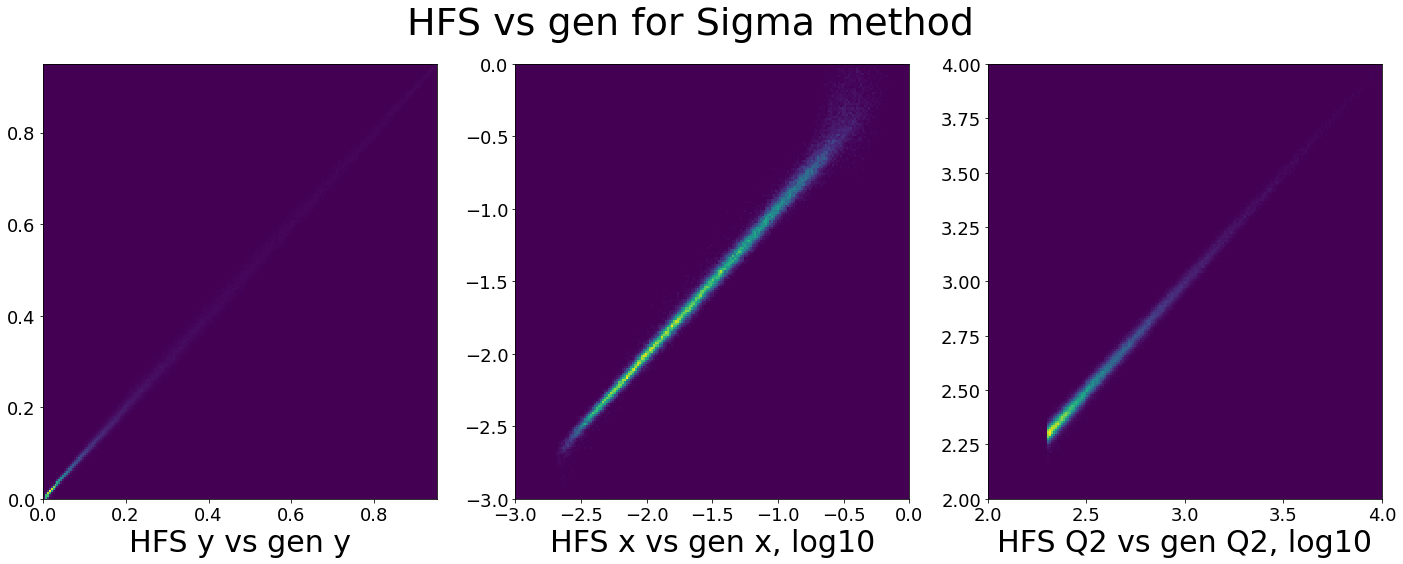

In [14]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
ax = ax.flatten()
ax[0].hist2d(mc['gen_y'],mc['y_sigma__HFS'], range = ([0,0.95],[0,0.95]), bins=200)
ax[1].hist2d(mc['log10_gen_x'],mc['log10_x_sigma__HFS'], range = ([-3,0],[-3,0]), bins=200)
ax[2].hist2d(mc['log10_gen_Q2'],mc['log10_Q2_sigma__HFS'], range = ([2,4],[2,4]), bins=200)

ax[0].set_xlabel('HFS y vs gen y', fontsize=30)
ax[1].set_xlabel('HFS x vs gen x, log10', fontsize=30)
ax[2].set_xlabel('HFS Q2 vs gen Q2, log10', fontsize=30)

fig.suptitle('HFS vs gen for Sigma method', fontsize=38)

plt.show()

These look pretty good for the most part.  The agreement gets worse below y = 0.01.

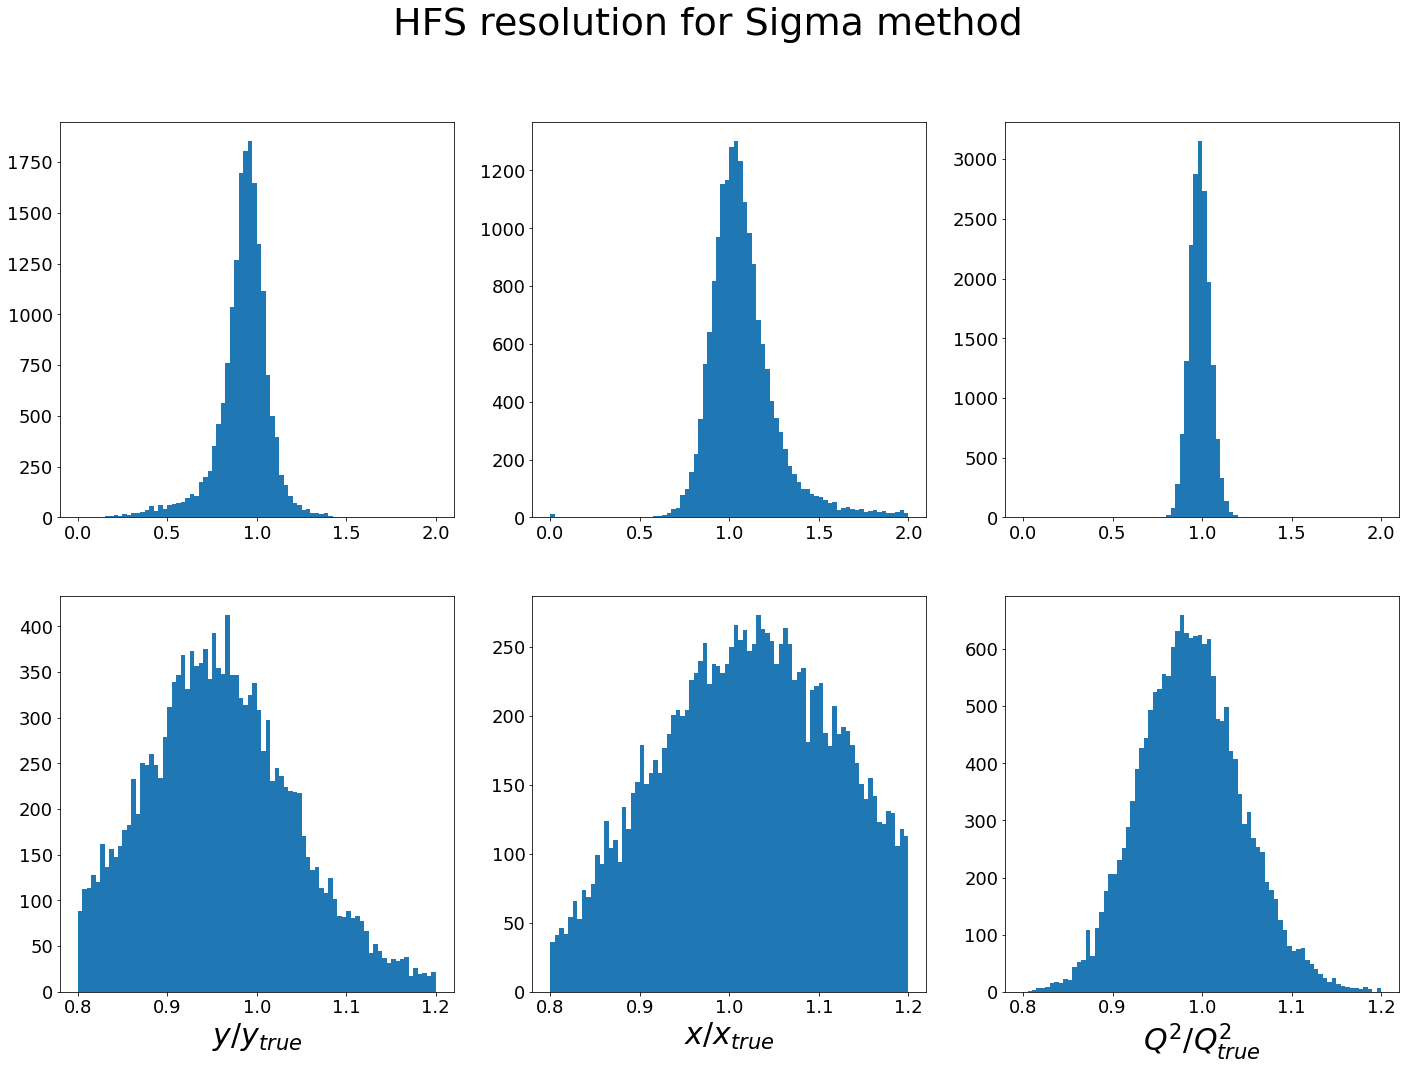

In [15]:


fig,ax = plt.subplots(2,3,figsize=(24,16))
ax = ax.flatten()

ax[0].hist(mc.query('gen_y>0.01 and gen_y<0.05')['yratio_sigma__HFS'], range = (ratio_plot_wide_min, ratio_plot_wide_max), bins=80)
ax[1].hist(mc.query('gen_y>0.01 and gen_y<0.05')['xratio_sigma__HFS'], range = (ratio_plot_wide_min, ratio_plot_wide_max), bins=80)
ax[2].hist(mc.query('gen_y>0.01 and gen_y<0.05')['Q2ratio_sigma__HFS'], range = (ratio_plot_wide_min, ratio_plot_wide_max), bins=80)

ax[3].hist(mc.query('gen_y>0.01 and gen_y<0.05')['yratio_sigma__HFS'], range = (ratio_plot_zoom_min, ratio_plot_zoom_max), bins=80)
ax[4].hist(mc.query('gen_y>0.01 and gen_y<0.05')['xratio_sigma__HFS'], range = (ratio_plot_zoom_min, ratio_plot_zoom_max), bins=80)
ax[5].hist(mc.query('gen_y>0.01 and gen_y<0.05')['Q2ratio_sigma__HFS'], range = (ratio_plot_zoom_min, ratio_plot_zoom_max), bins=80)

ax[3].set_xlabel('$y/y_{true}$', fontsize=30)
ax[4].set_xlabel('$x/x_{true}$', fontsize=30)
ax[5].set_xlabel('$Q^2/Q^2_{true}$', fontsize=30)

fig.suptitle('HFS resolution for Sigma method', fontsize=38)

plt.show()

This is far from perfect but pretty good.  Looks like 3% error on y and x just from acceptance is not crazy.

## Double Angle method: 2D plots and plots of rec/gen for x,y,Q2

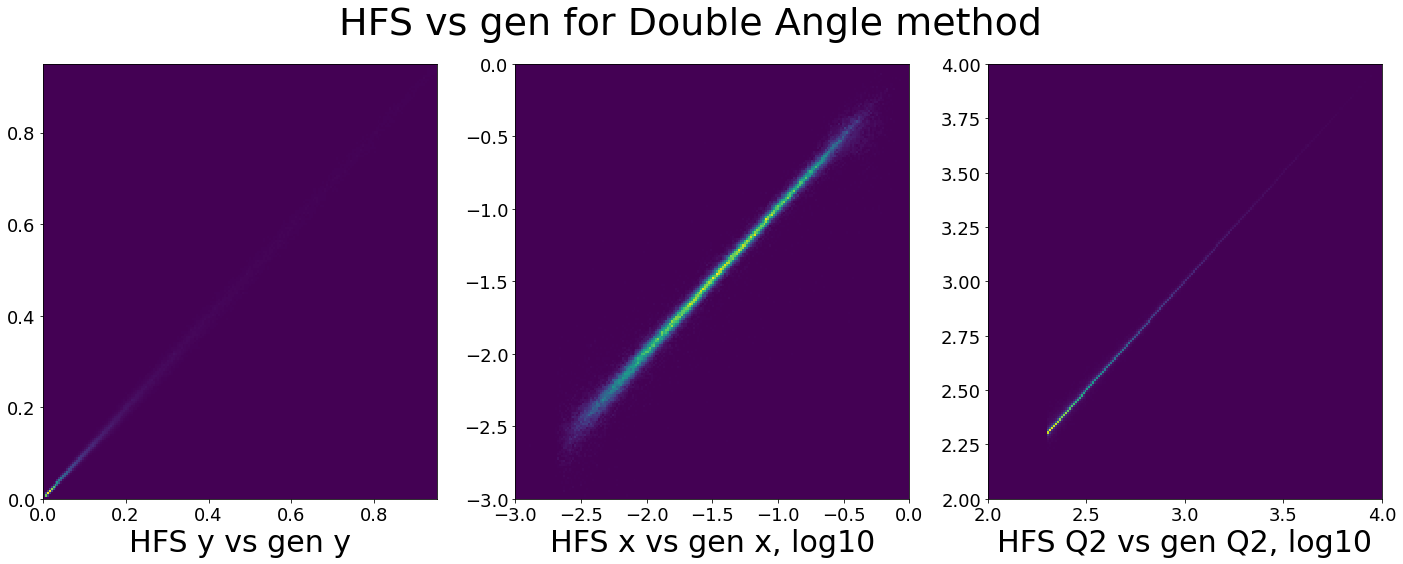

In [22]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
ax = ax.flatten()
ax[0].hist2d(mc['gen_y'],mc['y_da__HFS'], range = ([0,0.95],[0,0.95]), bins=200)
ax[1].hist2d(mc['log10_gen_x'],mc['log10_x_da__HFS'], range = ([-3,0],[-3,0]), bins=200)
ax[2].hist2d(mc['log10_gen_Q2'],mc['log10_Q2_da__HFS'], range = ([2,4],[2,4]), bins=200)

ax[0].set_xlabel('HFS y vs gen y', fontsize=30)
ax[1].set_xlabel('HFS x vs gen x, log10', fontsize=30)
ax[2].set_xlabel('HFS Q2 vs gen Q2, log10', fontsize=30)

fig.suptitle('HFS vs gen for Double Angle method', fontsize=38)

plt.show()

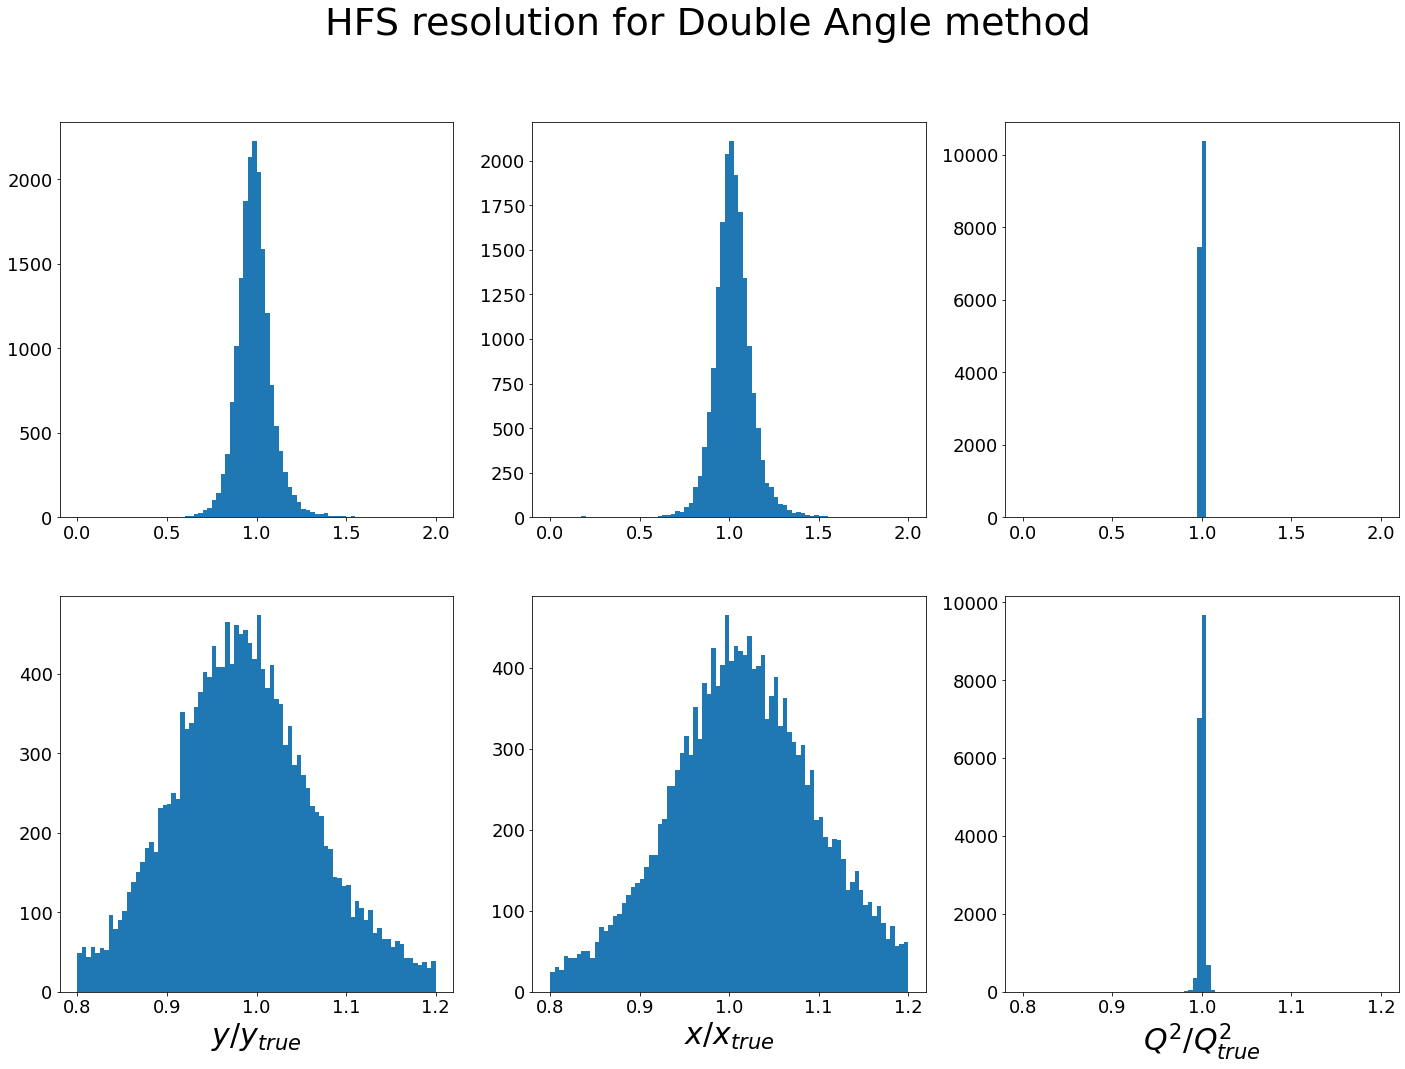

In [29]:



fig,ax = plt.subplots(2,3,figsize=(24,16))
ax = ax.flatten()

ax[0].hist(mc.query('gen_y>0.01 and gen_y<0.05')['yratio_da__HFS'], range = (ratio_plot_wide_min, ratio_plot_wide_max), bins=80)
ax[1].hist(mc.query('gen_y>0.01 and gen_y<0.05')['xratio_da__HFS'], range = (ratio_plot_wide_min, ratio_plot_wide_max), bins=80)
ax[2].hist(mc.query('gen_y>0.01 and gen_y<0.05')['Q2ratio_da__HFS'], range = (ratio_plot_wide_min, ratio_plot_wide_max), bins=80)

ax[3].hist(mc.query('gen_y>0.01 and gen_y<0.05')['yratio_da__HFS'], range = (ratio_plot_zoom_min, ratio_plot_zoom_max), bins=80)
ax[4].hist(mc.query('gen_y>0.01 and gen_y<0.05')['xratio_da__HFS'], range = (ratio_plot_zoom_min, ratio_plot_zoom_max), bins=80)
ax[5].hist(mc.query('gen_y>0.01 and gen_y<0.05')['Q2ratio_da__HFS'], range = (ratio_plot_zoom_min, ratio_plot_zoom_max), bins=80)

ax[3].set_xlabel('$y/y_{true}$', fontsize=30)
ax[4].set_xlabel('$x/x_{true}$', fontsize=30)
ax[5].set_xlabel('$Q^2/Q^2_{true}$', fontsize=30)

fig.suptitle('HFS resolution for Double Angle method', fontsize=38)


plt.show()

Significantly worse than I expected!  This method seems to work very well in the fast simulation.




## Hadron method: 2D plots and plots of rec/gen for x,y,Q2

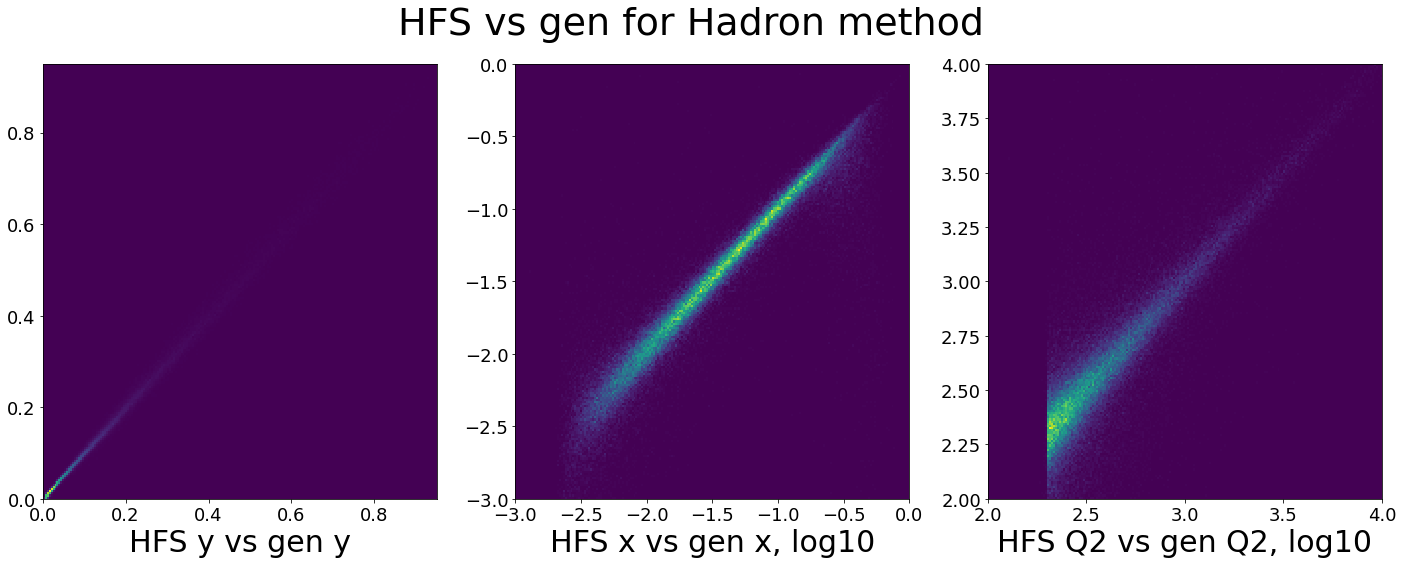

In [27]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
ax = ax.flatten()
ax[0].hist2d(mc['gen_y'],mc['y_h__HFS'], range = ([0,0.95],[0,0.95]), bins=200)
ax[1].hist2d(mc['log10_gen_x'],mc['log10_x_h__HFS'], range = ([-3,0],[-3,0]), bins=200)
ax[2].hist2d(mc['log10_gen_Q2'],mc['log10_Q2_h__HFS'], range = ([2,4],[2,4]), bins=200)

ax[0].set_xlabel('HFS y vs gen y', fontsize=30)
ax[1].set_xlabel('HFS x vs gen x, log10', fontsize=30)
ax[2].set_xlabel('HFS Q2 vs gen Q2, log10', fontsize=30)

fig.suptitle('HFS vs gen for Hadron method', fontsize=38)


plt.show()

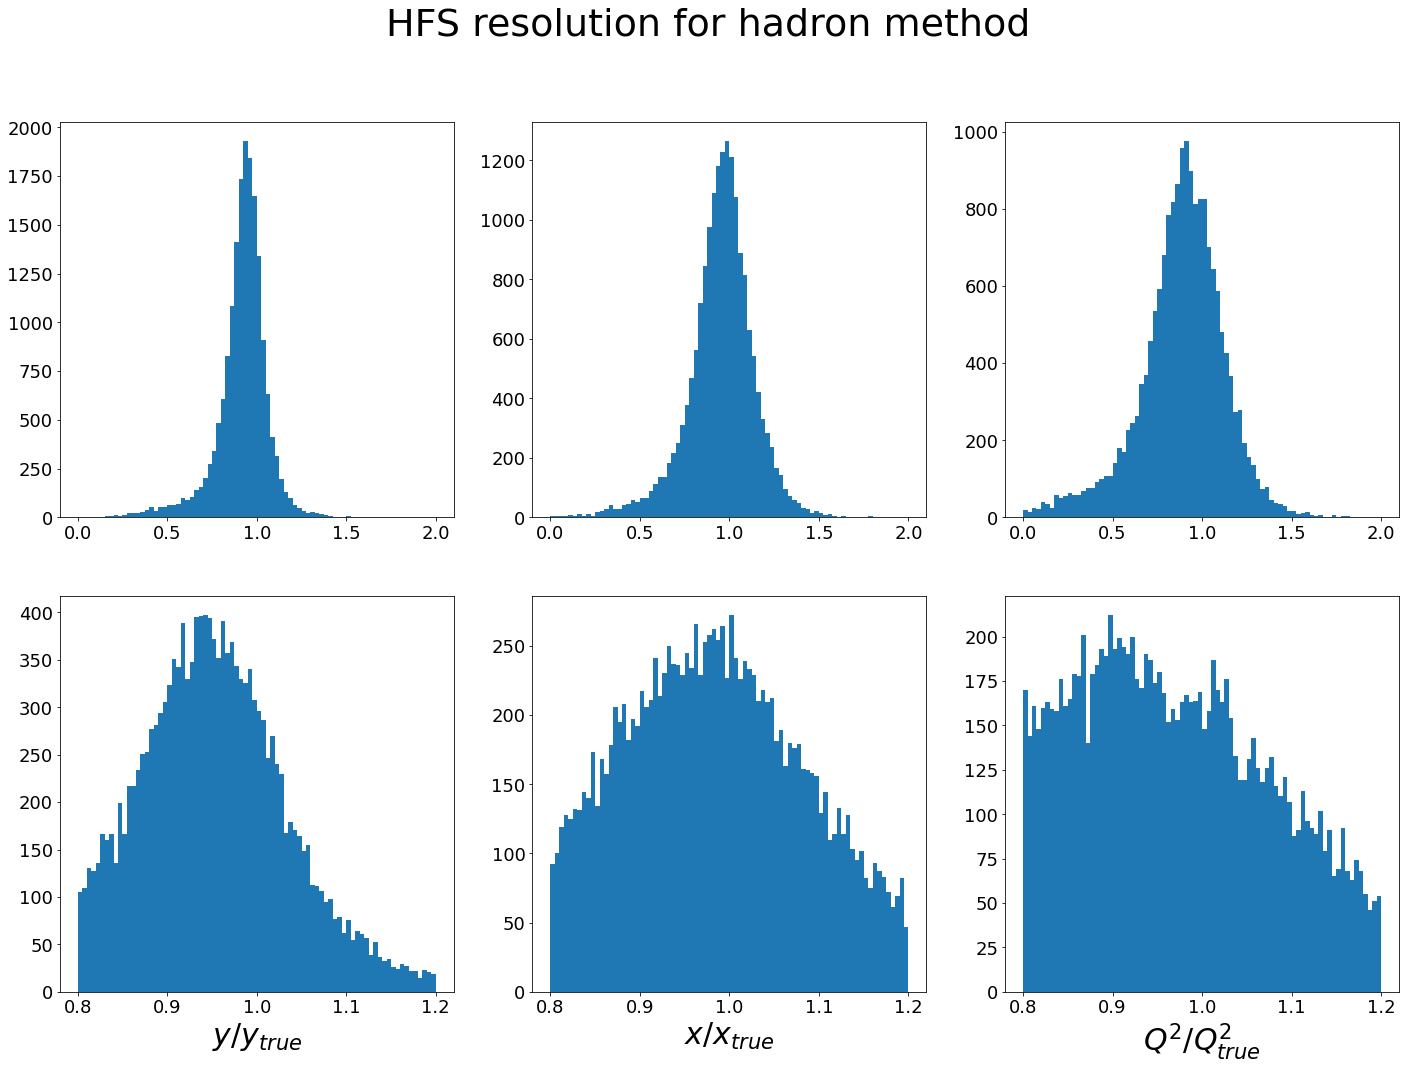

In [28]:
fig,ax = plt.subplots(2,3,figsize=(24,16))
ax = ax.flatten()

ax[0].hist(mc.query('gen_y>0.01 and gen_y<0.05')['yratio_h__HFS'], range = (ratio_plot_wide_min, ratio_plot_wide_max), bins=80)
ax[1].hist(mc.query('gen_y>0.01 and gen_y<0.05')['xratio_h__HFS'], range = (ratio_plot_wide_min, ratio_plot_wide_max), bins=80)
ax[2].hist(mc.query('gen_y>0.01 and gen_y<0.05')['Q2ratio_h__HFS'], range = (ratio_plot_wide_min, ratio_plot_wide_max), bins=80)

ax[3].hist(mc.query('gen_y>0.01 and gen_y<0.05')['yratio_h__HFS'], range = (ratio_plot_zoom_min, ratio_plot_zoom_max), bins=80)
ax[4].hist(mc.query('gen_y>0.01 and gen_y<0.05')['xratio_h__HFS'], range = (ratio_plot_zoom_min, ratio_plot_zoom_max), bins=80)
ax[5].hist(mc.query('gen_y>0.01 and gen_y<0.05')['Q2ratio_h__HFS'], range = (ratio_plot_zoom_min, ratio_plot_zoom_max), bins=80)

ax[3].set_xlabel('$y/y_{true}$', fontsize=30)
ax[4].set_xlabel('$x/x_{true}$', fontsize=30)
ax[5].set_xlabel('$Q^2/Q^2_{true}$', fontsize=30)

fig.suptitle('HFS resolution for hadron method', fontsize=38)

plt.show()

Again, surprisingly poor in x and Q2.

## Some conclusions

Pure acceptance affects can be important, perhaps even limiting factors in some of these methods.
For those acceptance-limited methods, improving reconstruction resolution won't help at all.

The Sigma methods seems to be the best and does a reasonable job in all 3 (x,y,Q2).

The Double Angle method is ok in x and y and pretty good for Q2.

The Hadron method is pretty good for y and quite poor for x and Q2.